In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import openpyxl

In [5]:
# コピー元のパス・シート指定
file_path = Path(Path.home(), "DataFile", "testDataFile.xlsx")
sheet_name_list = ["J1 (50MPa) (金型修正用)", "J1 (50MPa) (2)", "J2（60MPa)", "J2（60MPa)"]

In [7]:
# xlsxファイルの読み込みとデータ整理
#元データ
original_df = pd.read_excel(file_path,sheet_name=sheet_name_list, skiprows=7, \
skipfooter=45, header=[0,1,2,3], index_col = 1)

#シート
original_dfs = [original_df[sheet_name_list[sheet_number]].drop(('Unnamed: 0_level_0',\
'Unnamed: 0_level_1', 'Unnamed: 0_level_2', 'Unnamed: 0_level_3'), axis=1) for sheet_number in range(len(sheet_name_list))]
sample_dfs = [original_dfs[sheet_number].drop(['Nominal', 'Up Tol.', 'Low Tol.']) for sheet_number in range(len(sheet_name_list))]
statistics_dfs = [original_dfs[sheet_number].copy().head(3) for sheet_number in range(len(sheet_name_list))]

In [8]:
# 統計量等の行をstatistics_dfに追加
for sheet_number in range(len(sheet_name_list)):
    statistics_dfs[sheet_number].loc["Average"] = sample_dfs[sheet_number].mean() #n30平均値
    statistics_dfs[sheet_number].loc["Max_sample"] = sample_dfs[sheet_number].max() #n30最大値
    statistics_dfs[sheet_number].loc["Min_sample"] = sample_dfs[sheet_number].min() #n30最小値
    statistics_dfs[sheet_number].loc["Difference"] = statistics_dfs[sheet_number].loc["Max_sample"] - statistics_dfs[sheet_number].loc["Min_sample"] #n30最大-最小
    statistics_dfs[sheet_number].loc["Sigma"] = sample_dfs[sheet_number].std() #n30標準偏差
    statistics_dfs[sheet_number].loc["Ave+3Sigma"] = statistics_dfs[sheet_number].loc["Average"] + 3*statistics_dfs[sheet_number].loc["Sigma"]#n30平均値+3Sigma
    statistics_dfs[sheet_number].loc["Ave-3Sigma"] = statistics_dfs[sheet_number].loc["Average"] - 3*statistics_dfs[sheet_number].loc["Sigma"]#n30平均値-3Sigma
    statistics_dfs[sheet_number].loc["Upper_Limit"] = statistics_dfs[sheet_number].loc["Nominal"] + statistics_dfs[sheet_number].loc["Up Tol."] #最大寸法
    statistics_dfs[sheet_number].loc["Lower_Limit"] = statistics_dfs[sheet_number].loc["Nominal"] + statistics_dfs[sheet_number].loc["Low Tol."] #最小寸法
    statistics_dfs[sheet_number].loc["Center_Line"] = (statistics_dfs[sheet_number].loc["Upper_Limit"] + statistics_dfs[sheet_number].loc["Lower_Limit"])/2 #中央寸法
    statistics_dfs[sheet_number].loc["Process_Capability_Index"] = (statistics_dfs[sheet_number].loc["Upper_Limit"]\
    - statistics_dfs[sheet_number].loc["Lower_Limit"])/(6*statistics_dfs[sheet_number].loc["Sigma"]) #プロセス能力指数

        # 統計量(Cpk)行をstatistic_dfに追加, where構文で条件づけてデータを追加する
    upperCPk = (statistics_dfs[sheet_number].loc["Upper_Limit"] - statistics_dfs[sheet_number].loc["Average"])/(3*statistics_dfs[sheet_number].loc["Sigma"])
    lowerCPk = (statistics_dfs[sheet_number].loc["Average"] - statistics_dfs[sheet_number].loc["Lower_Limit"])/(3*statistics_dfs[sheet_number].loc["Sigma"])
    Cpk = upperCPk.where(upperCPk < lowerCPk, lowerCPk)
    statistics_dfs[sheet_number].loc["Cpk"] = Cpk

In [9]:
#グラフ作成に必要なdataframe
dfs=[statistics_dfs[sheet_number].loc[["Cpk", "Sigma", "Upper_Limit", "Lower_Limit", "Average",\
"Max_sample", "Min_sample", "Ave+3Sigma", "Ave-3Sigma"]]for sheet_number in range(len(sheet_name_list))]

In [10]:
#Multiple columnsをmargeしてdfsを再定義
for sheet_number in range(len(sheet_name_list)):
    columns_integer = "Dim"
    columns_marge = [None] * len(dfs[sheet_number].columns)  # 48に相当するカラム数に合わせてリストを初期化

    for i in range(len(dfs[sheet_number].columns)):
        for j in range(4):
            if  "Unnamed" not in str(dfs[sheet_number].columns[i][j]) :
                columns_integer += "_" + str(dfs[sheet_number].columns[i][j])
        columns_marge[i] = columns_integer
        columns_integer = "Dim"

    dfs[sheet_number] = pd.DataFrame(dfs[sheet_number].values, index = dfs[sheet_number].index, columns = columns_marge)

In [11]:
plt_dfs = [dfs[sheet_number].copy().drop(['Cpk', 'Sigma']) for sheet_number in range(len(sheet_name_list))]

In [17]:
with pd.ExcelWriter("output.xlsx") as writer:
    for i in range(len(sheet_name_list)):
        plt_dfs[i].to_excel(writer ,sheet_name=sheet_name_list[i])

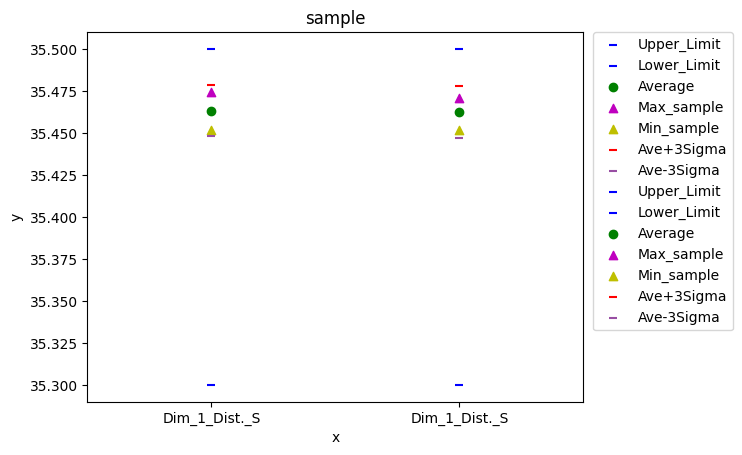

In [12]:
#グラフ
marker_list = ["_", "_", "o", "^", "^", "_", "_"]
color_list =  ["b", "b", "g", "m", "y", "r", '#984ea3']

fig, ax = plt.subplots()

for index in range(len(plt_dfs[0].index)):
    ax.scatter(x=1, y=plt_dfs[0].values[index][0], \
    marker=marker_list[index], color=color_list[index], label=plt_dfs[0].index[index])

for index in range(len(plt_dfs[1].index)):
    ax.scatter(x=2, y=plt_dfs[1].values[index][0], \
    marker=marker_list[index], color=color_list[index], label=plt_dfs[1].index[index])

ax.set_title("sample")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xticks([1.0, 2.0])
ax.set_xticklabels([plt_dfs[0].columns[0], plt_dfs[1].columns[0]])
ax.set_xlim(0.5, 2.5)

ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1.0,), borderaxespad=0)

plt.savefig("sample.png", dpi = 600)
plt.show()

AttributeError: 'list' object has no attribute 'values'

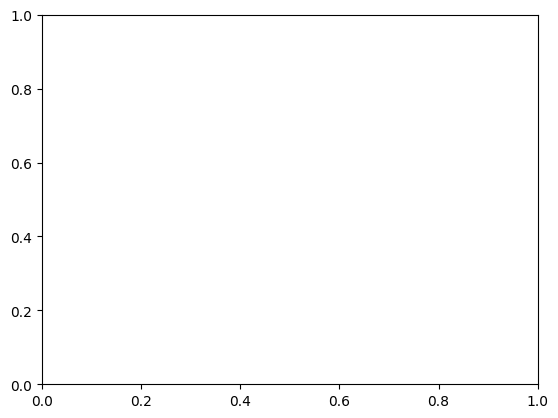

In [32]:
marker_list = ["_", "_", "o", "^", "^", "_", "_"]
color_list =  ["b", "b", "g", "m", "y", "r", '#984ea3']

fig, ax = plt.subplots()

x_range = [i+1 for i in range(len(sheet_name_list))]

for index in range(len(plt_dfs[0].index)):
    if index == 0 or index == 1 :
        #ax.plot(x_range, [plt_dfs[0].values[index][0], plt_dfs[1].values[index][0]], \
        #color=color_list[index], label=plt_dfs[0].index[index])
        ax.plot(x_range, plt_dfs.values[index][0], \
        color=color_list[index], label=plt_dfs[0].index[index])
    else:
        ax.scatter(x=x_range, y=plt_dfs.values[index][0], \
        marker=marker_list[index], color=color_list[index], label=plt_dfs[0].index[index])


ax.set_title("sample")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xticks(x_range)
ax.set_xticklabels([plt_dfs[0].columns[0], plt_dfs[1].columns[0]])
ax.set_xlim([0.5, 3.5])

ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1.0,), borderaxespad=0)

plt.savefig("sampleB.png", bbox_inches='tight', dpi = 600)
plt.show()

In [30]:
x_range = [i + 1 for i in range(len(sheet_name_list))]
x_range


[1, 2, 3, 4]

In [14]:
#試作
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import openpyxl

# コピー元のパス・シート指定
file_path = Path(Path.home(), "DataFile", "testDataFile.xlsx")
sheet_name_list = ["J1 (50MPa) (金型修正用)", "J1 (50MPa) (2)", "J2（60MPa)", "J2（60MPa)"]

original_df = pd.read_excel(file_path,sheet_name=sheet_name_list, skiprows=7, \
skipfooter=45, header=[0,1,2,3], index_col = 1)

original_df = {sheet_name : df.drop(('Unnamed: 0_level_0',\
'Unnamed: 0_level_1', 'Unnamed: 0_level_2', 'Unnamed: 0_level_3'), axis=1) \
for sheet_name, df in original_df.items()}
sample_df = {sheet_name : df.drop(['Nominal', 'Up Tol.', 'Low Tol.']) for sheet_name, df in original_df.items()}
#statistics_df = {sheet_name : df.head(3) for sheet_name, df in original_df.items()}

In [15]:
statistics_df = {sheet_name: pd.DataFrame([df.mean()], index=['Average']) for sheet_name, df in sample_df.items()}
statistics_df = {sheet_name : pd.DataFrame([df.max()], index=["Max_Sample"]) for sheet_name, df in sample_df.items()} #n30最大値
statistics_df = {sheet_name : pd.DataFrame([df.min()], index=["Min_Sample"]) for sheet_name, df in sample_df.items()} #n30最小値
statistics_df = {sheet_name : pd.DataFrame([df.max()-df.min()], index=["Difference"]) for sheet_name, df in sample_df.items()} #最大ー最小
statistics_df = {sheet_name : pd.DataFrame([df.std()], index=["Difference"]) for sheet_name, df in sample_df.items()} #n30標準偏差
statistics_df = {sheet_name : pd.DataFrame([df.std()], index=["Difference"]) for sheet_name, df in sample_df.items()}


In [32]:
    statistics_dfs[sheet_number].loc["Ave+3Sigma"] = statistics_dfs[sheet_number].loc["Average"] + 3*statistics_dfs[sheet_number].loc["Sigma"]#n30平均値+3Sigma
    statistics_dfs[sheet_number].loc["Ave-3Sigma"] = statistics_dfs[sheet_number].loc["Average"] - 3*statistics_dfs[sheet_number].loc["Sigma"]#n30平均値-3Sigma
    statistics_dfs[sheet_number].loc["Upper_Limit"] = statistics_dfs[sheet_number].loc["Nominal"] + statistics_dfs[sheet_number].loc["Up Tol."] #最大寸法
    statistics_dfs[sheet_number].loc["Lower_Limit"] = statistics_dfs[sheet_number].loc["Nominal"] + statistics_dfs[sheet_number].loc["Low Tol."] #最小寸法
    statistics_dfs[sheet_number].loc["Center_Line"] = (statistics_dfs[sheet_number].loc["Upper_Limit"] + statistics_dfs[sheet_number].loc["Lower_Limit"])/2 #中央寸法
    statistics_dfs[sheet_number].loc["Process_Capability_Index"] = (statistics_dfs[sheet_number].loc["Upper_Limit"]\
    - statistics_dfs[sheet_number].loc["Lower_Limit"])/(6*statistics_dfs[sheet_number].loc["Sigma"]) #プロセス能力指数

        # 統計量(Cpk)行をstatistic_dfに追加, where構文で条件づけてデータを追加する
    upperCPk = (statistics_dfs[sheet_number].loc["Upper_Limit"] - statistics_dfs[sheet_number].loc["Average"])/(3*statistics_dfs[sheet_number].loc["Sigma"])
    lowerCPk = (statistics_dfs[sheet_number].loc["Average"] - statistics_dfs[sheet_number].loc["Lower_Limit"])/(3*statistics_dfs[sheet_number].loc["Sigma"])
    Cpk = upperCPk.where(upperCPk < lowerCPk, lowerCPk)
    statistics_dfs[sheet_number].loc["Cpk"] = Cpk

Dimension                  1        2                                      3  \
Point     Unnamed: 2_level_1       TL        BL        BR       TR        TL   
Contents               Dist.    Dist.     Dist.     Dist.    Dist.         Z   
Rank                       S        S         S         S        S         S   
Average            35.463087  9.95068  9.961643  9.961207  9.93714  6.525437   

Dimension                                                 4  ...  \
Point            BL        BR        TR Unnamed: 11_level_1  ...   
Contents          Z         Z         Z               Dist.  ...   
Rank              S         S         S                   S  ...   
Average    6.526587  6.541737  6.496513             4.26176  ...   

Dimension                  19                  20        21  \
Point     Unnamed: 40_level_1 Unnamed: 41_level_1        p1   
Contents                Dist.               Dist.     Dist.   
Rank                        S                   S         S   
Average              11.94741            12.00271  18.71282   

Dimension                                                     \
Point                                 p2                       
Contents                   演算      Dist.                  演算   
Rank      Unnamed: 43_level_3          S Unnamed: 45_level_3   
Average             18.828013  18.800043           18.915236   

Dimension                                      22                  23  \
Point                         Unnamed: 47_level_1 Unnamed: 48_level_1   
Contents                                    Dist.               Dist.   
Rank      Unnamed: 46_level_3                   S                   S   
Average                   NaN            0.128287            0.096147   

Dimension                      
Point     Unnamed: 49_level_1  
Contents               Weight  
Rank                        A  
Average             21.670667  

[1 rows x 48 columns]

In [40]:
# FigureとAxesを作成
fig, ax = plt.subplots()

# Sheet1のデータをプロット（シート1には青色を使用）
ax.scatter(['Sheet1']*len(data_sheet1), data_sheet1, color='blue', label='Sheet1')

# Sheet2のデータをプロット（シート2には赤色を使用）
ax.scatter(['Sheet2']*len(data_sheet2), data_sheet2, color='red', label='Sheet2')

# グラフの設定
ax.set_title(f"Scatter Plot of '{column_name}' in 'Sheet1' and 'Sheet2'")
ax.set_xlabel('Sheet Name')
ax.set_ylabel(column_name)
ax.legend()

# グラフを表示
plt.show()

In [46]:
# 列名のリスト（系列A, 系列B）
column_names = ['系列A', '系列B']

# 使用可能なシート名のリスト
sheet_names = list(all_sheets.keys())

# 各系列に対して散布図を作成
for column_name in column_names:
    # FigureとAxesを作成
    fig, ax = plt.subplots()

    # 使用可能なすべてのシートからデータを抽出してプロット
    for sheet_name in sheet_names:
        df = all_sheets.get(sheet_name)
        if df is not None and column_name in df.columns:
            data = df[column_name]
            ax.scatter([sheet_name]*len(data), data, label=sheet_name)

    # グラフの設定
    ax.set_title(f"Scatter Plot of '{column_name}' in Sheets")
    ax.set_xlabel('Sheet Name')
    ax.set_ylabel(column_name)
    ax.legend()

    # グラフを表示
    plt.show()

In [20]:
original_df = pd.read_excel(file_path,sheet_name=sheet_name_list, skiprows=7, \
skipfooter=45, header=[0,1,2,3], index_col = 1)

original_df = {sheet_name : df.drop(('Unnamed: 0_level_0',\
'Unnamed: 0_level_1', 'Unnamed: 0_level_2', 'Unnamed: 0_level_3'), axis=1) \
for sheet_name, df in original_df.items()}

original_df["J1 (50MPa) (金型修正用)"]

Dimension                  1        2                                  3  \
Point     Unnamed: 2_level_1       TL       BL       BR       TR      TL   
Contents               Dist.    Dist.    Dist.    Dist.    Dist.       Z   
Rank                       S        S        S        S        S       S   
Nominal              35.4000  10.0000  10.0000  10.0000  10.0000  6.5000   
Up Tol.               0.1000   0.0000   0.0000   0.0000   0.0000  0.0500   
Low Tol.             -0.1000  -0.1000  -0.1000  -0.1000  -0.1000 -0.0500   
1                    35.4630   9.9507   9.9621   9.9594   9.9386  6.5249   
2                    35.4653   9.9497   9.9616   9.9590   9.9377  6.5234   
3                    35.4615   9.9474   9.9617   9.9607   9.9371  6.5233   
4                    35.4564   9.9476   9.9608   9.9592   9.9337  6.5236   
5                    35.4535   9.9487   9.9607   9.9605   9.9359  6.5243   
6                    35.4515   9.9460   9.9589   9.9582   9.9344  6.5247   
7                    35.4659   9.9472   9.9620   9.9609   9.9354  6.5251   
8                    35.4630   9.9465   9.9605   9.9611   9.9351  6.5262   
9                    35.4640   9.9538   9.9642   9.9599   9.9406  6.5233   
10                   35.4608   9.9574   9.9662   9.9634   9.9395  6.5277   
11                   35.4658   9.9568   9.9635   9.9620   9.9385  6.5268   
12                   35.4598   9.9523   9.9628   9.9606   9.9383  6.5239   
13                   35.4677   9.9518   9.9634   9.9617   9.9389  6.5269   
14                   35.4641   9.9492   9.9593   9.9615   9.9349  6.5253   
15                   35.4594   9.9521   9.9595   9.9618   9.9382  6.5234   
16                   35.4567   9.9503   9.9599   9.9600   9.9355  6.5261   
17                   35.4581   9.9480   9.9599   9.9622   9.9329  6.5276   
18                   35.4585   9.9507   9.9611   9.9604   9.9380  6.5259   
19                   35.4671   9.9501   9.9660   9.9648   9.9401  6.5265   
20                   35.4643   9.9558   9.9675   9.9671   9.9425  6.5289   
21                   35.4642   9.9465   9.9591   9.9585   9.9326  6.5283   
22                   35.4637   9.9500   9.9604   9.9607   9.9341  6.5250   
23                   35.4622   9.9499   9.9597   9.9574   9.9355  6.5272   
24                   35.4606   9.9491   9.9600   9.9586   9.9353  6.5242   
25                   35.4697   9.9501   9.9623   9.9626   9.9349  6.5255   
26                   35.4743   9.9540   9.9659   9.9636   9.9430  6.5239   
27                   35.4676   9.9504   9.9611   9.9624   9.9363  6.5262   
28                   35.4707   9.9505   9.9616   9.9612   9.9378  6.5254   
29                   35.4668   9.9531   9.9553   9.9617   9.9392  6.5231   
30                   35.4664   9.9547   9.9623   9.9651   9.9397  6.5265   

Dimension                                           4  ...  \
Point          BL      BR      TR Unnamed: 11_level_1  ...   
Contents        Z       Z       Z               Dist.  ...   
Rank            S       S       S                   S  ...   
Nominal    6.5000  6.5000  6.5000              4.2500  ...   
Up Tol.    0.0500  0.0500  0.0500              0.1000  ...   
Low Tol.  -0.0500 -0.0500 -0.0500              0.0000  ...   
1          6.5246  6.5413  6.4959              4.2602  ...   
2          6.5263  6.5418  6.4978              4.2600  ...   
3          6.5236  6.5412  6.4957              4.2588  ...   
4          6.5253  6.5393  6.4946              4.2595  ...   
5          6.5261  6.5391  6.4951              4.2629  ...   
6          6.5243  6.5404  6.4961              4.2613  ...   
7          6.5253  6.5412  6.4957              4.2619  ...   
8          6.5265  6.5412  6.4971              4.2635  ...   
9          6.5257  6.5410  6.4955              4.2580  ...   
10         6.5273  6.5444  6.4956              4.2587  ...   
11         6.5263  6.5445  6.4965              4.2623  ...   
12         6.5254  6.5414  6.4975              4.2631  ...   
13       